In [1]:
import numpy as np
import sympy as sp
import torch as pt
from tqdm import tqdm
import scipy 
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)
pt.manual_seed(0)

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Exercise 2
## ISOKANN
ISOKANN is an algorithm that uses machine learning techniques to identify invariant subspaces of the Koopman operator.
In this exercise, we will learn how it works when applied to a one-dimensional system.

#### System parameters

In [2]:
kB     = 0.008314463                 # kJ mol-1 K
T      = 300                         # K   
mass   = 1                           # amu
gamma  = 1                           # ps-1 
sigma  = np.sqrt(2 * kB * T / mass / gamma )              # nm ps-1/2
beta   = 1 / kB / T                  # kJ-1 mol 

print("Thermal energy:", kB * T)

Thermal energy: 2.4943389


#### Potential energy function

Text(0.5, 0, 'x')

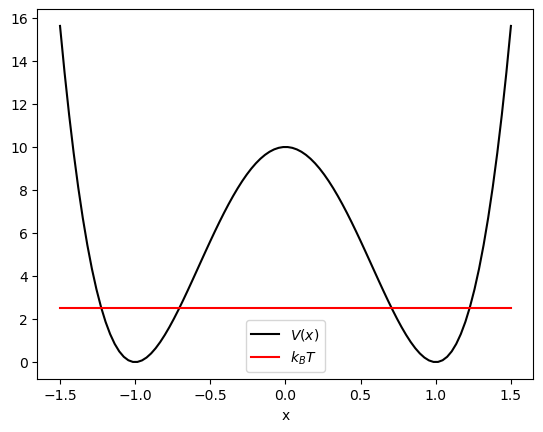

In [3]:
Eb     =  10
x      =  sp.symbols('x')
V      =  Eb*(x**2 - 1)**2

#a = 0.3
#V      =  - 1 / beta * sp.log( sp.exp( - ( x - 1 ) ** 2 / a ) + sp.exp( - ( x + 1 ) ** 2 / a ) )

gradV  =  V.diff(x)

V      =  sp.lambdify((x), V, modules=['numpy'])
gradV  =  sp.lambdify((x), gradV, modules=['numpy'])

x      =  np.linspace(-1.5, 1.5,100)
plt.plot(x, V(x), 'k-', label = r'$V(x)$')
plt.plot(x, kB*T*np.ones(100),'r', label = r'$k_B T$')
plt.legend()
plt.xlabel('x')

Load the data set of initial points $x_0$.
Load the data set of final points $x_t$.

200
(200, 300)


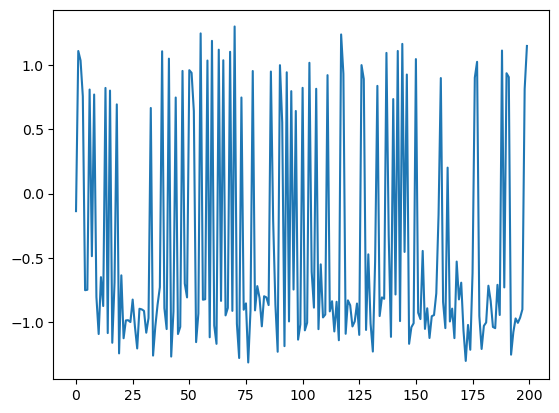

In [4]:
# Load initial points
x0 = np.loadtxt('x0.txt')
plt.plot(x0)

Npoints = len(x0)
print(Npoints)

# Load final points
xt = np.loadtxt('xt.txt')
print(xt.shape)

Npoints = xt.shape[0]  # == len(x0)
Nreps   = xt.shape[1]

# Length of each trajectory (this information isu used later for rate estimation)
Nsteps = 200
# Integrator time step used for simulations
dt     = 0.001

In the next cell define the NN and the training function that you implemented in exercise 1.

In [5]:
class NeuralNetwork(pt.nn.Module):
    def __init__(self, Nodes, enforce_positive=0):
        super(NeuralNetwork, self).__init__()

        # self parameters
        self.input_size        = Nodes[0]
        self.output_size       = Nodes[-1]
        self.NhiddenLayers     = len(Nodes) - 2
        self.Nodes             = Nodes
        
        self.enforce_positive  = enforce_positive

        # build NN architecture
        self.hidden_layers = pt.nn.ModuleList()

        # add layers
        self.hidden_layers.extend([pt.nn.Linear(self.input_size,    self.Nodes[1])])
        self.hidden_layers.extend([pt.nn.Linear(self.Nodes[1+l], self.Nodes[1+l+1]) for l in range(self.NhiddenLayers)])

        # the output of the last layer must be equal to 1
        #if self.Nodes[-1] > 1:
        #    self.hidden_layers.extend([pt.nn.Linear(self.Nodes[-1], 1)])

        # define activation function
        self.activation1  = pt.nn.Sigmoid()  # #
        self.activation2  = pt.nn.ReLU() 
        self.activation3  = pt.nn.Softplus(10)
        
    def forward(self, X):

        # Pass input through each hidden layer but the last one
        for layer in self.hidden_layers[:-1]:
            X = self.activation1(layer(X))

        # Apply the last layer (but not the activation function)
        X = self.hidden_layers[-1](X)

        if self.enforce_positive == 1:
            X= self.activation3(X)  #.unsqueeze(1)

        return X.squeeze()

def trainNN(net, lr, wd, Nepochs, batch_size, X, Y):

    # Early stopping parameters
    # Stop training if this metric no longer improves after a certain number of epochs (patience).
    patience = 10
    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    # Split training and validation data
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

    # Define the optimizer
    optimizer = pt.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

    # Define the loss function
    MSE = pt.nn.MSELoss()
        
    # Define an array where to store the loss
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(Nepochs):

        permutation = pt.randperm(X_train.size()[0])

        for i in range(0, X_train.size()[0], batch_size):
            
            # Clear gradients for next training
            optimizer.zero_grad()
            
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], Y_train[indices]
            
            # Make a new prediction
            new_points  =  net( batch_x )
            
            # measure the MSE
            loss = MSE(batch_y, new_points)

            # computes the gradients of the loss with respect to the model parameters using backpropagation.
            loss.backward()

            # updates the NN parameters
            optimizer.step()

        train_losses.append(loss.item())

        # Validation
        with pt.no_grad():
            val_outputs = net(X_val)
            val_loss    = MSE(val_outputs, Y_val)
            val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = net.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                #print(f"Early stopping at epoch {epoch+1}")
                break

        #print(f'Epoch {epoch+1}/{Nepochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

    return train_losses, val_losses, best_loss

def power_method(pt_x0, pt_xt, f_NN, scale_and_shift, Niters = 500, tolerance  = 5e-3, lr = 1e-3):

    """
    train_LOSS, val_LOSS, best_loss = power_method(pt_x0, pt_y, f_NN, scale_and_shift, Niters = 500, tolerance  = 5e-3)
    """
    train_LOSS = np.empty(0, dtype = object)
    val_LOSS   = np.empty(0, dtype = object)

    for i in tqdm(range(Niters)):

        old_chi =  f_NN(pt_x0).detach().numpy()

        pt_chi  =  f_NN( pt_xt )
        pt_y    =  pt.mean(pt_chi, axis=1)
        y       =  scale_and_shift(pt_y.detach().numpy())
        pt_y    =  pt.tensor(y, dtype=pt.float32)
        
        train_loss, val_loss, best_loss = trainNN(net = f_NN, lr = lr, wd = 1e-5, Nepochs = 10, batch_size=50, X=pt_x0, Y=pt_y)
        train_LOSS           = np.append(train_LOSS, train_loss[-1])
        val_LOSS             = np.append(val_LOSS, val_loss[-1])

        new_chi   = f_NN(pt_x0).detach().numpy()

        if np.linalg.norm(new_chi - old_chi) < tolerance:
            
            break

    return train_LOSS, val_LOSS, best_loss



# Random search for hyperparameters
def random_search(X, Y, search_iterations=20):

    hidden_layer_sizes = [(1, 32, 1), 
                          (1, 64, 1), 
                          (1, 32, 32, 1),
                          (1, 64, 64, 1), 
                          (1, 32, 64, 1)]

    learning_rates = [0.01, 
                      0.001, 
                      0.0001]

    best_hyperparams = None
    best_val_loss = float('inf')

    for _ in tqdm(range(search_iterations)):

        lr    = random.choice(learning_rates)
        nodes = np.asarray(random.choice(hidden_layer_sizes))

        f_NN = NeuralNetwork( Nodes = nodes, enforce_positive = 1 )

        train_losses, val_losses, val_loss = power_method(X, Y, f_NN, scale_and_shift, Niters = 100, tolerance  = 5e-3, lr = lr)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_hyperparams = {'nodes': nodes, 'learning_rate': lr}

    return best_hyperparams, best_val_loss




In the next cell implement the scale and shift function:

$$
\hat{y} = \frac{y - \min(y)}{\max(y) - \min(y)}
$$

In [6]:
def scale_and_shift(y):

    minarr = np.min(y)
    maxarr = np.max(y)
    hat_y  = (y - minarr) / (maxarr - minarr)

    return hat_y

Implement the ISOKANN algorithm:
\begin{eqnarray*}
    \hat{f}_{k+1} &=& \frac{\mathcal{S}\mathcal{K}(\tau) f_k}{\lVert \mathcal{S}\mathcal{K}(\tau) f_k \rVert} \cr 
    \lim_{k\rightarrow \infty } \hat{f}_{k+1} &=& \chi_i(x) \quad i=1,2
\end{eqnarray*}

For a two-state system, $\mathcal{S}$ is given by

\begin{eqnarray*}
    \mathcal{S}\mathcal{K}(\tau) f_k = \frac{\mathcal{K}(\tau) f_k - \min\left(\mathcal{K}(\tau) f_k\right)}{\max\left(\mathcal{K}(\tau) f_k\right) - \min\left(\mathcal{K}(\tau) f_k\right)}
\end{eqnarray*}

The action of the Koopman operator on a function is approximated as

\begin{eqnarray}
   \mathcal{K}(\tau)f(x) &=& \mathbb{E}\left[ f(x_{\tau})\vert x_0 = x\right] \cr
    &\approx& \frac{1}{N} \sum_{n=1}^N f(x_{\tau,n}) = \bar{f}(x_{\tau}) \, ,
\end{eqnarray}

where $x_{\tau,n}$ is the end-point of the $n$th simulation of length $\tau$ starting in $x_0 = x$.

In [7]:

# Convert the datasets x0 and xt to torch
pt_x0     =  pt.tensor(x0, dtype=pt.float32).unsqueeze(1)
pt_xt     =  pt.tensor(xt, dtype=pt.float32).unsqueeze(2)


best_hyperparams, best_val_loss = random_search(pt_x0, pt_xt, search_iterations=10)

print(best_hyperparams)

nodes = best_hyperparams['nodes']
lr    = best_hyperparams['learning_rate']
# Define the NN
f_NN = NeuralNetwork( Nodes = np.asarray(nodes), enforce_positive = 1 )
#f_NN = NeuralNetwork3()
train_LOSS, val_LOSS, best_loss = power_method(pt_x0, pt_xt, f_NN, scale_and_shift, Niters = 500, tolerance  = 5e-3, lr = lr)

chi   = f_NN(pt_x0).detach().numpy()



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.82s/it]


{'nodes': array([ 1, 32, 64,  1]), 'learning_rate': 0.01}


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [00:51<00:15,  7.43it/s]


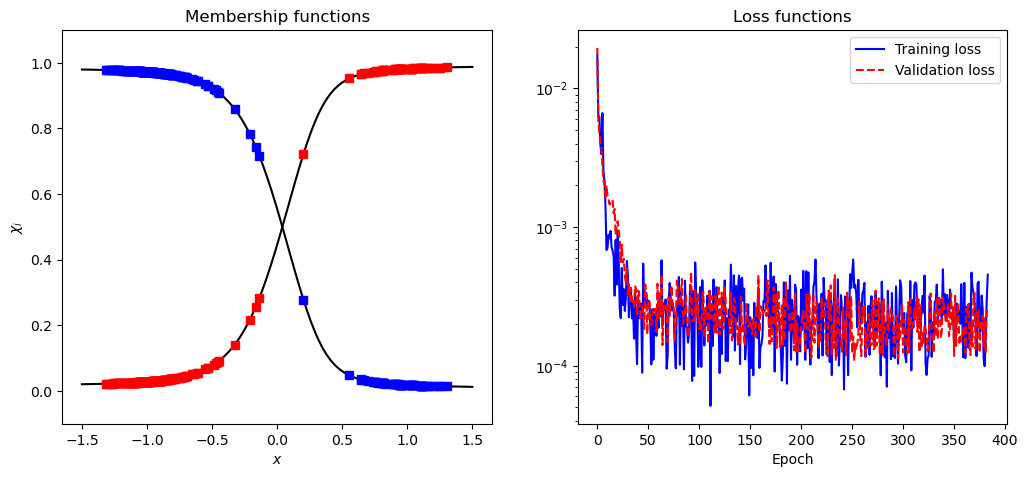

In [8]:
pt_x = pt.tensor(x, dtype=pt.float32).unsqueeze(1)
y    = f_NN(pt_x).detach().numpy()


fig = plt.figure(figsize=(24*in2cm, 10*in2cm))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x, y, 'k')
ax.plot(x,1- y, 'k')

ax.plot(x0, chi,   'sb')
ax.plot(x0, 1-chi,   'sr')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\chi_i$')
ax.set_title('Membership functions')

ax.set_ylim(-0.1,1.1);

ax = fig.add_subplot(1, 2, 2)
ax.plot(train_LOSS, 'b', label='Training loss')
ax.plot(val_LOSS,   'r--', label='Validation loss')

ax.set_xlabel('Epoch')
ax.set_title('Loss functions')
#ax.set_ylim(0,0.01)
ax.set_yscale('log')
ax.legend()

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)
fig.savefig('chi_1D.png', format='png', dpi=300, bbox_inches='tight')

The Koopman operator acts on $\chi(x)$ as

\begin{eqnarray*}
\chi(x,t+\tau) &=& \mathcal{K}(\tau) \chi(x,t) \cr
&=& \gamma_1 \chi(x,t) + \gamma_2\, .
\end{eqnarray*}

From linear regression we can estimate $\gamma_1$ and $\gamma_2$, and exit rates:

\begin{eqnarray*}
\kappa = - \frac{1}{\tau} \log(\gamma_1) \left( 1 + \frac{\gamma_2}{\gamma_1 - 1}\right)
\end{eqnarray*}

In [9]:
def exit_rates_from_chi(Nsteps, dt, chi, prop_chi):
    
    # lag time
    tau       = Nsteps * dt

    res1 = scipy.stats.linregress(chi, prop_chi)

    rate1  = - 1 / tau * np.log( res1.slope ) * ( 1 + res1.intercept  / ( res1.slope - 1 ))
    
    print('Exit rate 1:', rate1)
    print("")

    return rate1

In [10]:
# Calculate the propagated chi
pt_chi_t  = f_NN(pt_xt)
pt_chi_t  = pt.mean( pt_chi_t, axis=1 )

chi_t = pt_chi_t.detach().numpy()

rate12_1  = exit_rates_from_chi(Nsteps, dt, chi, chi_t)

Exit rate 1: 0.14342580710880645

